Practical 1: Sentiment Detection of Movie Reviews
========================================



This practical concerns sentiment detection of movie reviews.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task (how might one go about classifying the texts?); you will write
code that decides whether a random unseen movie review is positive or
negative.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Bo Pang’s system. If you have questions about it,
we should resolve them in our first demonstrated practical.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Environment**

All code should be written in **Python 3**. 
If you use Colab, check if you have that version with `Runtime -> Change runtime type` in the top menu.

> If you want to work in your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.

#### Learning Python 3

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

Loading the Data
-------------------------------------------------------------

In [0]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2018-11-23 13:33:49--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.1s    

2018-11-23 13:33:54 (6.30 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2018-11-23 13:33:55--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151

In [0]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# load reviews into memory
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# For documentation on POS-tags, see 
# https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print(len(reviews))

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("#types", len(c))

print("Most common tokens:")
for token, count in c.most_common(25):
  print("%10s : %8d" % (token, count))
  

2000
0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
#types 47743
Most common tokens:
       

Symbolic approach – sentiment lexicon (2pts)
---------------------------------------------------------------------



**How** could one automatically classify movie reviews according to their
sentiment? 

If we had access to a **sentiment lexicon**, then there are ways to solve
the problem without using Machine Learning. One might simply look up
every open-class word in the lexicon, and compute a binary score
$S_{binary}$ by counting how many words match either a positive, or a
negative word entry in the sentiment lexicon $SLex$.

$$S_{binary}(w_1w_2...w_n) = \sum_{i = 1}^{n}\text{sgn}(SLex\big[w_i\big])$$

**Threshold.** In average there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1w_2...w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{else }
        \end{array}
$$

To implement this approach, you should use the sentiment
lexicon in `sent_lexicon`, which was taken from the
following work:

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

#### (Q: 1.1) Implement this approach and report its classification accuracy. (1 pt)

In [0]:
# Turn lexicon into dictionary

lexicon_temp = open('sent_lexicon').read()
lexicon_temp = lexicon_temp.split()
for i in range(len(lexicon_temp)):
  lexicon_temp[i]=lexicon_temp[i].split('=')  
lexicon_len = len(lexicon_temp)//6 #Length of each line
lexicon = dict()
for i in range(lexicon_len):
  lexicon[i] = {}

k = 0
for i in range(0, len(lexicon_temp), 6):
  lexicon[k] = dict(zip(['type', 'len', 'word1', 'pos1', 'stemmed1', 'priorpolarity'], [lexicon_temp[i][1], lexicon_temp[i+1][1], lexicon_temp[i+2][1], lexicon_temp[i+3][1], lexicon_temp[i+4][1], lexicon_temp[i+5][1]]))
  k += 1

dict2 = {}

for i in lexicon:
  dict2[lexicon[i]['word1']] = lexicon[i]['priorpolarity']

dict3 = {}
for i in lexicon:
  dict3[lexicon[i]['word1']] = lexicon[i]['type']
  
k = 0
accuracy = 0
neg_tonkens = 0
pos_tonkens = 0
token_results = []
review_classify = [None] * 2000
for review in reviews:
  balance = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      try:
        if (dict2[token.lower()] == "negative"):
          balance-=1
        elif (dict2[token.lower()] == "positive"):
          balance+=1
        else:
          pass
      except KeyError:
        pass
  # predict review
  if balance>8:
    review_classify[k] = ['POS', balance]
  else:
    review_classify[k] = ['NEG', balance]
  # check if our prediction is correct 
  if review['sentiment'] == review_classify[k][0]:
      accuracy += 1
      token_results.append('+')
  else:
    token_results.append('-')
  k+=1

token_accuracy = accuracy /2000 


In [0]:
token_results = token_results
token_accuracy = token_accuracy
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


If the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we could take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Their lexicon also records two possible magnitudes of sentiment (*weak*
and *strong*), so you can implement both the binary and the weighted
solutions (please use a switch in your program). For the weighted
solution, you can choose the weights intuitively *once* before running
the experiment.

#### (Q: 1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [0]:
# Magnitude information

k = balance = accuracy = neg_weak_tonkens = neg_strong_tonkens = pos_weak_tonkens = pos_strong_tonkens = 0 

magnitude_results = []
review_classify_mag = [None] * 2000
for review in reviews:
  balance = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      try: 
        if (dict2[token.lower()] == "negative"):
          if(dict3[token.lower()] == "weaksubj"):
            balance -= 0.6
            neg_weak_tonkens += 1
          else:
            balance -= 1.7
            neg_strong_tonkens += 1
        elif(dict2[token.lower()] == 'positive'):
          if(dict3[token.lower()] == 'weaksubj'):
            balance += 0.6
            pos_weak_tonkens += 1
          else:
            balance += 1.7
            pos_strong_tonkens += 1
        else:
          continue
      except KeyError:
        pass
  if balance>8: 
    review_classify_mag[k] = ['POS', balance]
  else:
    review_classify_mag[k] = ['NEG', balance]

  if review['sentiment'] == review_classify_mag[k][0]:
      accuracy += 1
      magnitude_results.append('+')
  else:
      magnitude_results.append('-')
  k+=1

magnitude_accuracy = accuracy/k

In [0]:
magnitude_results = magnitude_results
magnitude_accuracy = magnitude_accuracy
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.69


#### Optional: make a barplot of the two results.

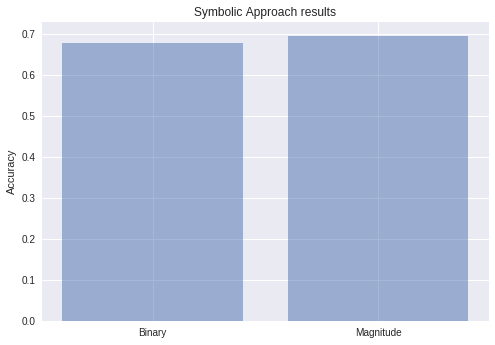

In [0]:
objects = ('Binary', 'Magnitude')
y_pos = np.arange(len(objects))
accuracy = [token_accuracy, magnitude_accuracy]

plt.bar(y_pos, accuracy, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Symbolic Approach results')
 
plt.show()

Answering questions in statistically significant ways (1pt)
-------------------------------------------------------------

Does using the magnitude improve the results? Oftentimes, answering questions like this about the performance of
different signals and/or algorithms by simply looking at the output
numbers is not enough. When dealing with natural language or human
ratings, it’s safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are really just
noise. 

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

In this experiment, $q = 0.5$. Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 


#### (Q 2.1): Implement the sign test. Is the difference between the two symbolic systems significant? What is the p-value? (1 pt)

You should use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.

You can quickly verify the correctness of
your sign test code using a [free online
tool](https://www.graphpad.com/quickcalcs/binomial1.cfm).

In [0]:
from decimal import Decimal
from scipy.special import comb

def sign_test(results_1, results_2):
  """test for significance
  results_1 is a list of classification results (+ for correct, - incorrect)
  results_2 is a list of classification results (+ for correct, - incorrect)
  """
  ties, plus, minus = 0, 0, 0

  # "-" carries the error
  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]=="-": 
      plus += 1
    elif results_2[i]=="-": 
      minus += 1

  q = 0.5
  N = 2 * math.ceil(ties/2) + plus + minus
  k = math.ceil(ties/2) + min(plus, minus)

  summation = Decimal(0.0)
  
  for i in range(0, k + 1):
    summation += Decimal(comb(N, i, exact=True)) * (Decimal(0.5)**Decimal(N))
      
  # use two-tailed version of test
  summation *= 2
  
  print("The difference is", 
        "not significant" if summation >= 0.05 else "significant")
  
  return summation

p = sign_test(token_results, magnitude_results)
print('p-value:',"{0:.4f}".format(p))

The difference is not significant
p-value: 0.4472


## Using the Sign test

**From now on, report all differences between systems using the
sign test.** You can think about a change that you apply to one system, as a
 new system.
    
You should report statistical test
results in an appropriate form – if there are several different methods
(i.e., systems) to compare, tests can only be applied to pairs of them
at a time. This creates a triangular matrix of test results in the
general case. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


Naive Bayes (8pt + 1pt bonus)
==========


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described in Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing text information as vectors (or points in space), making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text.

## Writing your own classifier

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you a position to replicate
    Pang et al., Naive Bayes results. However, the numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. You will find the
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, and store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.

#### (Q3.1) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining reviews cv900–cv999.  Report results using simple classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [0]:
import math
def NaiveBayes(trainData, testData):
  dictClassP = {}
  dictClassN = {}
  resultNBNoSmoothing = []
  noPosDocs = 0
  noNegDocs = 0
  for review in trainData:
    sentiment = review["sentiment"]  
    if(sentiment == "POS"):
      useDict = dictClassP
      noPosDocs += 1
    else:
      useDict = dictClassN
      noNegDocs += 1
    for sentence in review["content"]:
      for token, pos_tag in sentence:          
        if token.lower() in useDict:
          count = useDict[token.lower()]
          useDict[token.lower()] = count + 1
        else:
          useDict[token.lower()] = 1
        
  totalDocs = noPosDocs + noNegDocs
  probPos = noPosDocs/totalDocs
  probNeg = noNegDocs/totalDocs
  
  totalFreqClassP = sum(dictClassP.values())
  totalFreqClassN = sum(dictClassN.values())
  for token, freq in dictClassP.items():
    dictClassP[token]= freq/totalFreqClassP
  for token, freq in dictClassN.items():
    dictClassN[token] = freq/totalFreqClassN

  logClassP = math.log(probPos)
  logClassN = math.log(probNeg)
  
  accuracy = 0
  docCount = 0
  for review in testData:
    sentiment = review["sentiment"]
    docCount += 1
    eachTokenProbClassP = 0
    eachTokenProbClassN = 0
    for sentence in review["content"]:    
      for token, pos_tag in sentence:
        if(token.lower() in dictClassP):
          eachTokenProbClassP += math.log(dictClassP[token.lower()])
        if(token.lower() in dictClassN):  
          eachTokenProbClassN += math.log(dictClassN[token.lower()])
    probReviewInClassP = logClassP + eachTokenProbClassP
    probReviewInClassN = logClassN + eachTokenProbClassN
    if (probReviewInClassP >= probReviewInClassN):
      prediction = "POS"
    else:
      prediction = "NEG"
    if (prediction == sentiment):
      resultNBNoSmoothing.append("+")
    else:
      resultNBNoSmoothing.append("-")
      
  return resultNBNoSmoothing
  

# Split Data
trainData = [] 
testData = []
for review in reviews:
  cv = review["cv"]
  if (cv in range(0, 900)):
    trainData.append(review)
    
for review in reviews:
  cv = review["cv"]
  if (cv in range(900,1000)):
    testData.append(review)

# Get NB score
resultNBNoSmoothing = NaiveBayes(trainData, testData)
accuracy=resultNBNoSmoothing.count("+")/200

print("Accuracy of Naive Bayes:", 100 * accuracy,"%")


Accuracy of Naive Bayes: 49.5 %


#### (Bonus Questions) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

You can simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [0]:
import math
dictClassP = {}
dictClassN = {}
#dictNBPrediction = {}
noPosDocs = 0
noNegDocs = 0

for review in reviews:
  cv = review["cv"]
  
  sentiment = review["sentiment"]  
  if(sentiment == "POS"):
    if (cv not in range(0, 900)):
      continue
    useDict = dictClassP
    noPosDocs += 1
  else:
    if (cv not in range(0, 90)):
      continue
    useDict = dictClassN
    noNegDocs += 1
  for sentence in review["content"]:
    for token, pos_tag in sentence:          
      if token.lower() in useDict:
        count = useDict[token.lower()]
        useDict[token.lower()] = count + 1
      else:
        useDict[token.lower()] = 1
        
totalDocs = noPosDocs + noNegDocs
probPos = noPosDocs/totalDocs
probNeg = noNegDocs/totalDocs
totalFreqClassP = sum(dictClassP.values())
totalFreqClassN = sum(dictClassN.values())
for token, freq in dictClassP.items():
   dictClassP[token]= freq/totalFreqClassP
for token, freq in dictClassN.items():
  dictClassN[token] = freq/totalFreqClassN

logClassP = math.log(probPos)
logClassN = math.log(probNeg)
accuracy = 0
docCount = 0
for review in reviews:
  cv = review["cv"]
  sentiment = review["sentiment"]
  if((sentiment == "POS") and (cv not in range(900,1000)) or 
      ((sentiment == "NEG") and (cv not in range(900, 910)))):
    continue
  docCount += 1  
  eachTokenProbClassP = 0
  eachTokenProbClassN = 0
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      if(token.lower() in dictClassP):
        eachTokenProbClassP += math.log(dictClassP[token.lower()])
      if(token.lower() in dictClassN):
        eachTokenProbClassN += math.log(dictClassN[token.lower()])
  probReviewInClassP = logClassP + eachTokenProbClassP
  probReviewInClassN = logClassN + eachTokenProbClassN
  if (probReviewInClassP > probReviewInClassN):
    #dictNBPrediction[cv] = "POS"
    prediction = "POS"
  else:
    #dictNBPrediction[cv] = "NEG"
    prediction = "NEG"
  if (prediction == sentiment):
    accuracy += 1
      

print("Accuracy:", "{0:.4f}".format(100 * accuracy/docCount),"%")

Accuracy: 9.0909 %


## Smoothing

The presence of words in the test dataset that
haven’t been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.2) Implement Laplace feature smoothing (1pt)
($smoothing(\cdot) = \kappa$, constant for all words) in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [0]:
import math
def NaiveBayesK(trainData, testData, printNoOfFeatures = 0):
  k = 1
  dictClassP = {}
  dictClassN = {}
  resultNBSmoothing = []
  noPosDocs = 0
  noNegDocs = 0
  vocabularySet = set() # --
  
  #Training the model
  for review in trainData:
    sentiment = review["sentiment"]  
    if(sentiment == "POS"):
      useDict = dictClassP
      noPosDocs += 1
    else:
      useDict = dictClassN
      noNegDocs += 1
    for sentence in review["content"]:
      for token, pos_tag in sentence:          
        if token.lower() in useDict:
          count = useDict[token.lower()]
          useDict[token.lower()] = count + 1
        else:
          useDict[token.lower()] = 1
          vocabularySet.add(token.lower()) # --
        
  totalDocs = noPosDocs + noNegDocs
  probPos = noPosDocs/totalDocs
  probNeg = noNegDocs/totalDocs
  
  # Number of features
  if(printNoOfFeatures):
    return len(vocabularySet)
    quit()
    
  totalFreqClassP = sum(dictClassP.values())
  totalFreqClassN = sum(dictClassN.values())

  
  for token, freq in dictClassP.items():
    dictClassP[token]= (freq + k)/(totalFreqClassP + (k * len(vocabularySet)))
    
  for token, freq in dictClassN.items():
    dictClassN[token] = (freq + k)/(totalFreqClassN + (k * len(vocabularySet)))

  
  #Testing the model
  logClassP = math.log(probPos)
  logClassN = math.log(probNeg)
  accuracy = 0
  docCount = 0
  for review in testData:
    sentiment = review["sentiment"]
    docCount += 1
    eachTokenProbClassP = 0
    eachTokenProbClassN = 0
    for sentence in review["content"]:    
      for token, pos_tag in sentence:
        if(token.lower() in dictClassP):
          eachTokenProbClassP += math.log(dictClassP[token.lower()])
        else:
          eachTokenProbClassP += math.log(k / (totalFreqClassP + (k * len(vocabularySet)))) # --
        if(token.lower() in dictClassN):
          eachTokenProbClassN += math.log(dictClassN[token.lower()])
        else:
          eachTokenProbClassN += math.log(k / (totalFreqClassN + (k * len(vocabularySet)))) # --
    probReviewInClassP = logClassP + eachTokenProbClassP
    probReviewInClassN = logClassN + eachTokenProbClassN
    if (probReviewInClassP > probReviewInClassN):
      prediction = "POS"
    else:
      prediction = "NEG"
    if (prediction == sentiment):
      accuracy += 1
      resultNBSmoothing.append("+")
    else:
      resultNBSmoothing.append("-")
      
  return resultNBSmoothing
  
# Split Data 
trainData = [] 
testData = []
for review in reviews:
  cv = review["cv"]
  if (cv in range(0, 900)):
    trainData.append(review)
    
for review in reviews:
  cv = review["cv"]
  if (cv in range(900, 1000)):
    testData.append(review)
    
#  Get NBS score
resultNBSmoothing = NaiveBayesK(trainData, testData)
accuracy=resultNBSmoothing.count("+")/200
print("Accuracy of Naive Bayes with Laplace feature smoothing:", 100*accuracy,'%')


Accuracy of Naive Bayes with Laplace feature smoothing: 82.5 %


#### (Q3.3) Is the difference between non smoothed (Q3.1) and smoothed (Q3.2) statistically significant? (0.5pt)

In [0]:
sign_test(resultNBNoSmoothing, resultNBSmoothing)

The difference is significant


Decimal('0.000003547178174130642586494974890')

Cross-validation

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is that we
end up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that’s better
and better on our data, but worse and worse at generalizing to new,
never-before seen data.

A simple method to guard against Type III errors is to use
cross-validation. In N-fold cross-validation, we divide the data into N
distinct chunks / folds. Then, we repeat the experiment N times, each
time holding out one of the chunks for testing, training our classifier
on the remaining N - 1 data chunks, and reporting performance on the
held-out chunk. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)

#### (Q3.4) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)






In [0]:
def do_cross_val(dataset, function_to_test_on, folds):
  split = [[] for j in range(folds)]
  for review in dataset:
    cv = review["cv"]
    split[(cv % folds)].append(review)  

  total_resultlist = []
  accuracyList = []
  k = 1
  for spl in split:
    b = [x for i,x in enumerate(split) if x!=spl] 
    resultlist = function_to_test_on(sum(b,[]),spl)
    accuracyList.append(resultlist.count("+")/200)
    total_resultlist += resultlist
    if k == 10:
      print('Cross-Validation #',k,':', 100 * (resultlist.count("+")/200),"%")
    else:
      print('Cross-Validation #',k,' :',100 * (resultlist.count("+")/200),"%")
    k += 1
  return accuracyList, total_resultlist
  
accuracy_NB_CV, total_result_NB_CV = do_cross_val(reviews, NaiveBayesK, 10)
  
print("Average Performance:", 100 * sum(accuracy_NB_CV)/len(accuracy_NB_CV),"%")

Cross-Validation # 1  : 79.0 %
Cross-Validation # 2  : 83.5 %
Cross-Validation # 3  : 81.0 %
Cross-Validation # 4  : 83.0 %
Cross-Validation # 5  : 77.5 %
Cross-Validation # 6  : 85.0 %
Cross-Validation # 7  : 83.0 %
Cross-Validation # 8  : 78.0 %
Cross-Validation # 9  : 82.5 %
Cross-Validation # 10 : 84.5 %
Average Performance: 81.7 %


#### (Q3.5) Write code to calculate and report variance, in addition to the final performance. (1pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [0]:
def calculateVariance(data):
  N = len(data)
  mean = sum(data)/N
  sqL = [(val - mean)**2 for idx, val in enumerate(data)]
  variance = sum(sqL)/N
  return variance

var = calculateVariance(accuracy_NB_CV)
print('Variance:',var)

Variance: 0.0006509999999999987


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

#### (Q3.6): A touch of linguistics (1pt)

Taking a step further, you can use stemming to
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.
 Also, you should do cross validation and concatenate the predictions from all folds to compute the significance.

In [0]:
import math
from nltk.stem import *
stemmer = PorterStemmer()
def NaiveBayesKStem(trainData, testData, printNoOfFeatures = 0):
  k = 1
  dictClassP = {}
  dictClassN = {}
  resultPorterNBSmoothing = []
  noPosDocs = 0
  noNegDocs = 0
  vocabularySet = set()
  
  #Training the model
  for review in trainData:
    sentiment = review["sentiment"]  
    if(sentiment == "POS"):
      useDict = dictClassP
      noPosDocs += 1
    else:
      useDict = dictClassN
      noNegDocs += 1
    for sentence in review["content"]:
      for token, pos_tag in sentence: 
        stemmedToken = stemmer.stem(token.lower())
        if stemmedToken in useDict:
          count = useDict[stemmedToken]
          useDict[stemmedToken] = count + 1
        else:
          useDict[stemmedToken] = 1
          vocabularySet.add(stemmedToken)

        
  totalDocs = noPosDocs + noNegDocs
  probPos = noPosDocs/totalDocs
  probNeg = noNegDocs/totalDocs
  
  #Number of features
  if (printNoOfFeatures):
    return len(vocabularySet)
    quit()
  
  totalFreqClassP = sum(dictClassP.values())
  totalFreqClassN = sum(dictClassN.values())

  
  for token, freq in dictClassP.items():
    dictClassP[token]= (freq + k)/(totalFreqClassP + (k * len(vocabularySet)))
  
  for token, freq in dictClassN.items():
    dictClassN[token] = (freq + k)/(totalFreqClassN + (k * len(vocabularySet)))

  
  #Testing the model
  logClassP = math.log(probPos)
  logClassN = math.log(probNeg)
  accuracy = 0
  docCount = 0
  for review in testData:
    sentiment = review["sentiment"]
    docCount += 1
    eachTokenProbClassP = 0
    eachTokenProbClassN = 0
    for sentence in review["content"]:    
      for token, pos_tag in sentence:
        stemmedToken = stemmer.stem(token.lower())
        if(stemmedToken in dictClassP):
          eachTokenProbClassP += math.log(dictClassP[stemmedToken])
        else:
          eachTokenProbClassP += math.log(k / (totalFreqClassP + (k * len(vocabularySet))))
        if(stemmedToken in dictClassN):
          eachTokenProbClassN += math.log(dictClassN[stemmedToken])
        else:
          eachTokenProbClassN += math.log(k / (totalFreqClassN + (k * len(vocabularySet))))
    probReviewInClassP = logClassP + eachTokenProbClassP
    probReviewInClassN = logClassN + eachTokenProbClassN
    if (probReviewInClassP > probReviewInClassN):
      prediction = "POS"
    else:
      prediction = "NEG"
    if (prediction == sentiment):
      accuracy += 1
      resultPorterNBSmoothing.append("+")
    else:
      resultPorterNBSmoothing.append("-")
      
  return resultPorterNBSmoothing


accuracy_NBK_CV, total_result_NBK_CV =  do_cross_val(reviews, NaiveBayesKStem, 10)
print("Average Performance using Porter's stemming algorithm:", "{0:.2f}".format(100* sum(accuracy_NBK_CV)/len(accuracy_NBK_CV)),'%')

Cross-Validation # 1  : 78.0 %
Cross-Validation # 2  : 84.0 %
Cross-Validation # 3  : 81.0 %
Cross-Validation # 4  : 85.0 %
Cross-Validation # 5  : 77.5 %
Cross-Validation # 6  : 83.5 %
Cross-Validation # 7  : 81.0 %
Cross-Validation # 8  : 77.5 %
Cross-Validation # 9  : 83.0 %
Cross-Validation # 10 : 84.0 %
Average Performance using Porter's stemming algorithm: 81.45 %


#### (Q3.7): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (0.5pt)


In [0]:
sign_test(total_result_NB_CV, total_result_NBK_CV)

The difference is not significant


Decimal('0.9287507758426057968438994566')

#### Q3.8: What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.2)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [0]:
def testNoOfFeatures(function):
  trainData = [] 
  testData = []
  for review in reviews:
    cv = review["cv"]
    if (cv in range(0, 900)):
      trainData.append(review)
    
  for review in reviews:
    cv = review["cv"]
    if (cv in range(900, 1000)):
      testData.append(review)
  
  if(function == 0):
    print("Number of features when using stemming:", NaiveBayesKStem(trainData, testData, 1))
  else:
    print("Number of features without using stemming:", NaiveBayesK(trainData, testData, 1))
  
testNoOfFeatures(0) 
testNoOfFeatures(1)

Number of features when using stemming: 32404
Number of features without using stemming: 45348


#### Q3.9: Putting some word order back in (0.5+0.5pt=1pt)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-grams** features. 
Retrain your classifier from (Q3.4) using **unigrams+bigrams** and
**unigrams+bigrams+trigrams** as features, and report accuracy and statistical significances (in comparison to the experiment at (Q3.4) for all 10 folds, and between the new systems).





In [0]:
import nltk
from nltk import ngrams

def NaiveBayesK_ngrams(trainData, testData, n=3, giveNoOfTestFeatures = 0):
  dictClassP = {}
  dictClassN = {}
  noDocsInClassP = 0
  noDocsInClassN = 0
  vocabularySet = set()
  
  for idx, review in enumerate(trainData):
    concatTrainReviews = []
    sentiment = review["sentiment"]
    if (sentiment == "POS"):
      useDict = dictClassP
      noDocsInClassP += 1
    else:
      useDict = dictClassN
      noDocsInClassN += 1
    for sentence in review["content"]:
      for token, pos_tag in sentence:
        
        concatTrainReviews.append(token.lower())
        if (token.lower() in useDict):
          useDict[token.lower()] += 1
        else :
          useDict[token.lower()] = 1
          vocabularySet.add(token.lower())
    
    splitRev = []
    for grams in range(2,n+1):
      splitr = list(ngrams(concatTrainReviews, grams))
      splitRev.extend(splitr)
    
    for rev in splitRev:      
      if(rev in useDict):
        useDict[rev] += 1
      else:
        vocabularySet.add(rev)
        useDict[rev] = 1
  
  
  totalDocs = noDocsInClassP + noDocsInClassN
  probPos = noDocsInClassP/totalDocs
  probNeg = noDocsInClassN/totalDocs
  logClassP = math.log(probPos)
  logClassN = math.log(probNeg)
  
  k = 1
  
  totalFreqClassP = sum(dictClassP.values())
  totalFreqClassN = sum(dictClassN.values())
  
  vocab = len(vocabularySet)
  if (giveNoOfTestFeatures):
    return vocab
  
  for token, freq in dictClassP.items():
    dictClassP[token]= (freq + k)/(totalFreqClassP + (k * vocab))
  for token, freq in dictClassN.items():
    dictClassN[token]= (freq + k)/(totalFreqClassN + (k * vocab))
  
  #print(dictClassP)
  resultNB_ngram = []
  model_accuracy = 0
  for idx, review in enumerate(testData):
    concatTestReviews = []
    sentiment = review["sentiment"]
    posProb = 0
    negProb = 0
    for sentence in review["content"]:
      for token, pos_tag in sentence:
        concatTestReviews.append(token.lower()) 
        if (token.lower() in dictClassP):
           posProb += math.log(dictClassP[token.lower()])
        else:
          posProb += math.log(k / (totalFreqClassP + (k * vocab)))
        if (token.lower() in dictClassN):
           negProb += math.log(dictClassN[token.lower()])
        else:
           negProb += math.log(k / (totalFreqClassN + (k * vocab)))
    splitRev = []
    for grams in range(2,n+1):
      splitr = list(ngrams(concatTestReviews, grams))
      splitRev.extend(splitr)
    for rev in splitRev:
      if (rev in dictClassP):
           posProb += math.log(dictClassP[rev])
      else:
           posProb += math.log(k / (totalFreqClassP + (k * vocab)))
      if (rev in dictClassN):
           negProb += math.log(dictClassN[rev])
      else:
           negProb += math.log(k / (totalFreqClassN + (k * vocab)))
    
    probInClassP = logClassP + posProb
    probInClassN = logClassN + negProb
    
    if (probInClassP >= probInClassN):
      predicted = "POS"
    else:
      predicted = "NEG"
    if (sentiment == predicted):
      model_accuracy += 1
      resultNB_ngram.append("+")
    else:
      resultNB_ngram.append("-")
      
  #print(model_accuracy)
  return resultNB_ngram

def cross_val(dataset, function_to_test_on, folds, n):
  split = [[] for j in range(folds)]
  for review in dataset:
    cv = review["cv"]
    split[(cv % folds)].append(review)  

  total_resultlist = []
  accuracyList = []
  k = 1
  for spl in split:
    b = [x for i,x in enumerate(split) if x!=spl] 
    resultlist = function_to_test_on(sum(b,[]),spl, n)
    accuracyList.append(resultlist.count("+")/200)
    total_resultlist += resultlist
    if k == 10:
      print('Cross-Validation #',k,':', 100 * (resultlist.count("+")/200),"%")
    else:
      print('Cross-Validation #',k,' :',100 * (resultlist.count("+")/200),"%")
    k += 1
  return accuracyList, total_resultlist

accuracy_NB_CV1, total_result_NB_CV1 = cross_val(reviews, NaiveBayesK_ngrams, 10, 2)
print("Average Performance of unigrams+bigrams:", "{0:.1f}".format(100*sum(accuracy_NB_CV1)/len(accuracy_NB_CV)),"%")
print("")
print("Classification performance difference of the bigram compared to that of the unigram:")
sign_test(total_result_NB_CV1, total_result_NBK_CV)

print("")
print("-----------------")
print("")

accuracy_NB_CV2, total_result_NB_CV2 = cross_val(reviews, NaiveBayesK_ngrams, 10, 3)
print("Average Performance of unigrams+bigrams+trigrams:", "{0:.2f}".format(100*sum(accuracy_NB_CV2)/len(accuracy_NB_CV)),'%')
print("")
print("Classification performance difference of the trigram compared to that of the unigram:")    
sign_test(total_result_NB_CV2, total_result_NBK_CV)

Cross-Validation # 1  : 80.0 %
Cross-Validation # 2  : 87.5 %
Cross-Validation # 3  : 83.5 %
Cross-Validation # 4  : 87.0 %
Cross-Validation # 5  : 80.5 %
Cross-Validation # 6  : 87.0 %
Cross-Validation # 7  : 82.5 %
Cross-Validation # 8  : 84.0 %
Cross-Validation # 9  : 86.0 %
Cross-Validation # 10 : 85.0 %
Average Performance of unigrams+bigrams: 84.3 %

Classification performance difference of the bigram compared to that of the unigram:
The difference is not significant

-----------------

Cross-Validation # 1  : 80.0 %
Cross-Validation # 2  : 88.5 %
Cross-Validation # 3  : 85.0 %
Cross-Validation # 4  : 88.5 %
Cross-Validation # 5  : 81.5 %
Cross-Validation # 6  : 89.5 %
Cross-Validation # 7  : 83.5 %
Cross-Validation # 8  : 83.0 %
Cross-Validation # 9  : 87.5 %
Cross-Validation # 10 : 84.5 %
Average Performance of unigrams+bigrams+trigrams: 85.15 %

Classification performance difference of the trigram compared to that of the unigram:
The difference is not significant


Decimal('0.1025862286532821302108088733')


#### Q3.10: How many features does the BoW model have to take into account now? (0.5pt)
How does this number compare (e.g., linear, square, cubed, exponential) to the number of features at (Q3.8)? 

Use the held-out training set once again for this.


In [0]:
trainData = [] 
testData = []
for review in reviews:
  cv = review["cv"]
  if (cv in range(0, 900)):
    trainData.append(review)

for review in reviews:
  cv = review["cv"]
  if (cv in range(900, 1000)):
    testData.append(review)
      
f1 = NaiveBayesK_ngrams(trainData, testData, 2, 1)
print("Total features of unigram+bigram:",f1)
f2 = NaiveBayesK_ngrams(trainData, testData, 3, 1)
print("Total features of unigram+bigram+trigram:", f2)

Total features of unigram+bigram: 471032
Total features of unigram+bigram+trigram: 1416686


# Support Vector Machines (4pts)


Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM.](http://scikit-learn.org/stable/modules/svm.html) with the default parameters.



#### (Q4.1): Train SVM and compare to Naive Bayes (2pt)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier from (Q3.4) and report the numbers.
Do cross validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import pandas as pd


def svm_clf(traindata, testdata):
  data = traindata + testdata
  def get_bow(data):
    bow = []
    for k, review in enumerate(data):
      bow.insert(k, {})
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          token = token.lower()
          if token in bow[k]:
            bow[k][token] += 1
          else:
            bow[k][token] = 1
    return bow

  # Get vectorized features
  X = get_bow(data)
  vec = DictVectorizer()
  X = vec.fit_transform(X)
  X = pd.DataFrame(X.todense(), columns = vec.get_feature_names())
  Y = []
  for review in traindata:
    Y.append(review["sentiment"])
  
  
  # Train the model
  clf = LinearSVC()
  clf.fit(X.iloc[:len(traindata),:], Y)

  # Evaluate the model
  y_pred = clf.predict(X.iloc[len(traindata):, :])
  resultsvm = []
  accuracy = 0
  
  for i, review in enumerate(testdata):
    if review['sentiment'] == y_pred[i]:
      resultsvm.append('+')
    else:
      resultsvm.append('-')
      
  return resultsvm

accuracy_svm_CV, total_result_svm_CV = do_cross_val(reviews, svm_clf, 10)
print('Average performance of SVM:', 100*np.mean(accuracy_svm_CV),'%')
print('')
print('Classification performance of the SVM classifier compared to that of the Naive Bayes classifier:')
sign_test(total_result_NB_CV, total_result_svm_CV)

Cross-Validation # 1  : 81.0 %
Cross-Validation # 2  : 79.5 %
Cross-Validation # 3  : 80.0 %
Cross-Validation # 4  : 84.0 %
Cross-Validation # 5  : 85.0 %
Cross-Validation # 6  : 81.5 %
Cross-Validation # 7  : 84.5 %
Cross-Validation # 8  : 85.0 %
Cross-Validation # 9  : 87.5 %
Cross-Validation # 10 : 84.0 %
Average performance of SVM: 83.2 %

Classification performance of the SVM classifier compared to that of the Naive Bayes classifier:
The difference is not significant


Decimal('0.5166977962573607869966679094')

### More linguistics

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you. Try to
replicate what Pang et al. were doing:



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significant? Why?  (1pt)


In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import pandas as pd


def svm_pos_clf(traindata, testdata):
  data = traindata + testdata
  def get_bow(data):
    bow = []
    for k, review in enumerate(data):
      bow.insert(k, {})
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          token = token.lower() + pos_tag
          if token in bow[k]:
            bow[k][token] += 1
          else:
            bow[k][token] = 1
    return bow

  # Get vectorized features
  X = get_bow(data)
  vec = DictVectorizer()
  X = vec.fit_transform(X)
  X = pd.DataFrame(X.todense(), columns = vec.get_feature_names())
  Y = []
  for review in traindata:
    Y.append(review["sentiment"])
  
  
  # Train the model
  clf = LinearSVC()
  clf.fit(X.iloc[:len(traindata),:], Y)

  # Evaluate the model
  y_pred = clf.predict(X.iloc[len(traindata):, :])
  resultsvm = []
  accuracy = 0
  
  for i, review in enumerate(testdata):
    if review['sentiment'] == y_pred[i]:
      resultsvm.append('+')
    else:
      resultsvm.append('-')
      
  return resultsvm

accuracy_svm_pos_CV, total_result_svm_pos_CV =  do_cross_val(reviews, svm_pos_clf, 10)

print('Average performance of SVM with POS:', "{0:.1f}".format(100*np.mean(accuracy_svm_pos_CV)),'%')

Cross-Validation # 1  : 82.0 %
Cross-Validation # 2  : 79.5 %
Cross-Validation # 3  : 82.5 %
Cross-Validation # 4  : 84.0 %
Cross-Validation # 5  : 84.0 %
Cross-Validation # 6  : 84.5 %
Cross-Validation # 7  : 85.5 %
Cross-Validation # 8  : 85.5 %
Cross-Validation # 9  : 86.5 %
Cross-Validation # 10 : 84.0 %
Average performance of SVM with POS: 83.8 %


#### (Q4.3) Discard all closed-class words from your data (keep only nouns (N*), verbs (V*), adjectives (J*) and adverbs (RB*)), and report performance. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? Why? (1pt)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import pandas as pd


def svm_closed_pos_clf(traindata, testdata):
  
  data = traindata + testdata
  open_classes = ['NNS', 'NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ', 'VBP','JJ','JJR','JJS', 'RB','RBR','RBS']
  def get_bow(data):
    bow = []
    for k, review in enumerate(data):
      bow.insert(k, {})
      for sentence in review["content"]:
        for token, pos_tag in sentence:
          if pos_tag in open_classes:
            token = token.lower() + pos_tag
            if token in bow[k]:
              bow[k][token] += 1
            else:
              bow[k][token] = 1
          else:
            continue
    return bow

  
  # Get vectorized features
  X = get_bow(data)
  vec = DictVectorizer()
  X = vec.fit_transform(X)
  X = pd.DataFrame(X.todense(), columns = vec.get_feature_names())
  Y = []
  for review in traindata:
    Y.append(review["sentiment"])
  
  
  # Train the model
  clf = LinearSVC()
  clf.fit(X.iloc[:len(traindata),:], Y)

  # Evaluate the model
  y_pred = clf.predict(X.iloc[len(traindata):, :])
  resultsvm = []
  accuracy = 0
  
  for i, review in enumerate(testdata):
    if review['sentiment'] == y_pred[i]:
      resultsvm.append('+')
    else:
      resultsvm.append('-')
      
  return resultsvm

accuracy_svm_closed_pos_CV, total_result_svm_closed_pos_CV =  do_cross_val(reviews, svm_closed_pos_clf, 10)

print('Average performance of SVM with Open Classes:', "{0:.4f}".format(np.mean(100*accuracy_svm_closed_pos_CV)),'%')

print('')
print('Classification performance of the SVM classifier compared to that of the SVM with Open Classes:')
sign_test(total_result_svm_pos_CV, total_result_svm_closed_pos_CV)

Cross-Validation # 1  : 80.5 %
Cross-Validation # 2  : 81.5 %
Cross-Validation # 3  : 82.5 %
Cross-Validation # 4  : 86.5 %
Cross-Validation # 5  : 87.0 %
Cross-Validation # 6  : 80.5 %
Cross-Validation # 7  : 86.5 %
Cross-Validation # 8  : 86.5 %
Cross-Validation # 9  : 85.0 %
Cross-Validation # 10 : 81.0 %
Average performance of SVM with Open Classes: 0.8375 %

Classification performance of the SVM classifier compared to that of the SVM with Open Classes:
The difference is not significant


Decimal('1.000000000000000000000000001')

Closed class words only provide structure to the open class words and do not carry any meaning themselves. Hence discarding or keeping them does not have any significant effect on the performance. 

# (Q8) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


Our task was to create a model that classifies review sentiment into positive or negative. 

Our first approach was to look up sentiment of every word of a review in a Sentiment Lexicon and evaluate the overall sentiment. This Symbolic approach considers only specific keywords in the text that we are interested in. But the Lexicon has a limited vocabulary and as a result, we could lose valuable information when discarding unknown words. Moreover, we lose the order and semantic of words (double negative phrases like “It was not bad” will not be evaluated correctly since sentiment of each word is assessed independently) and disregard the fact that some words have stronger impact than others. We try to tackle the latter by considering the magnitude information of the words in the lexicon, but the results are not significantly better maybe due to the chosen word weights.<br>

In the second approach, we use Naive Bayes classifier (NB). We transform the text data into Bag-of-Words(BoW) representation and the words themselves are used as features.  We train the the classifier using tagged, tokenized reviews and then use it to predict sentiment of new reviews. This classifier can be extremely biased if the training data is unbalanced. For example if 90% of the training data is positive reviews, new predictions will be skewed towards positive sentiment. 
The performance is also affected if there are words in the new reviews that are not included in the training vocabulary. To overcome this problem, we use Laplace smoothing which takes into account previously unseen words while making predictions. This improves the classifier performance notably.
The BoW representation does not use word order and grammatical structure information making this approach less effective. <br>

One of the problems with previous approaches is that the tokens are not normalized. To fix this, we use the Stemming approach, which reduces inflected words to the root of the word. However, this method fails on irregular forms (feet -> feet and not foot) and may produce non-words. Other than a decrease in feature size, there is no significant improvement in the performance using this technique.

To preserve some word order, we use ngrams technique, which uses sequence of n words as features providing some context information. Using trigrams and bigrams in addition to unigrams as features results in a huge increase in the features size without any drastic performance improvement. Probably the context information is still too less.<br>

Another classifier that doesn’t assume feature independence is the Support Vector Machine (SVM) classifier. The words and their frequency transformed to vectors are used as features and SVM finds the best hyperplane separating positive and negative reviews. We use this separation to make predictions. The results are not significantly better even after using syntax information of the text. Our tokens are labeled with a PoS text and can be classified into two classes - Open and Closed class. The latter includes words that provide structure for open-class PoS but do not carry any meaning. Therefore we remove these words reducing the number of features and maintain the same performance.<br>

To conclude, machine learnig approaches result in better classification. We believe combining mutiple techniques may improve the performace further.







# Submission 


In [0]:
# Write your names and student numbers here:
# Ioannis Gatopoulos #12141666
# Manasa J Bhat #12184306

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Also save your notebook as a Github Gist. Get it by choosing `File -> Save as Github Gist`.  Make sure that the gist has a secret link (not public).
- Check if your answers are all included in the file you submit (e.g. check the Github Gist URL)
- Submit your .ipynb file and link to the Github Gist via *Canvas*. One submission per group. 